<a href="https://colab.research.google.com/github/saif-islam-rayhan/Deep-Learning-Project/blob/main/Mod9ProjectObjectTrackingHeatmapVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install ultralytics supervision opencv-python numpy motpy tqdm matplotlib

In [7]:

import cv2
import numpy as np
from ultralytics import YOLO
from motpy import Detection, MultiObjectTracker
import supervision as sv
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
model = YOLO("yolov8n.pt")
tracker = MultiObjectTracker(dt=0.02)


# Load vedio

In [9]:
video_path = "https://media.roboflow.com/supervision/video-examples/people-walking.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(" Could not open video.")
else:
    print(" Video loaded successfully!")

 Video loaded successfully!


# Define parameters

In [10]:
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Two counting lines
line_up = int(frame_height * 0.4)
line_down = int(frame_height * 0.6)

# Counters
count_in = 0
count_out = 0

# Store trajectories
memory = {}
heatmap = np.zeros((frame_height, frame_width), np.float32)

# Output writer
out = cv2.VideoWriter("output_people_flow.mp4",
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))


# Process video

In [11]:
for _ in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, classes=[0])  # class 0 = person
    detections = []

    for r in results[0].boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = r
        # Convert to MOTPY Detection format (bounding box, score, class_id)
        detections.append(Detection(box=[x1, y1, x2, y2], score=score, class_id=class_id))

    if len(detections) > 0:
      tracked_objects = tracker.step(detections)
    else:
      tracked_objects = tracker.step([])


    for track in tracked_objects:
        x1, y1, x2, y2 = track.box
        obj_id = track.id
        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)

        if obj_id not in memory:
            memory[obj_id] = []
        memory[obj_id].append((cx, cy))

        # Update heatmap
        heatmap[cy-5:cy+5, cx-5:cx+5] += 1

        # Draw box and ID
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
        cv2.putText(frame, f"ID {obj_id}", (int(x1), int(y1)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        # Counting logic
        if len(memory[obj_id]) >= 2:
            y_prev = memory[obj_id][-2][1]
            y_now = memory[obj_id][-1][1]

            # Person moving down (IN)
            if y_prev < line_up and y_now >= line_up:
                count_in += 1

            # Person moving up (OUT)
            if y_prev > line_down and y_now <= line_down:
                count_out += 1

    # Draw counting lines
    cv2.line(frame, (0, line_up), (frame_width, line_up), (255, 0, 0), 2)
    cv2.line(frame, (0, line_down), (frame_width, line_down), (0, 0, 255), 2)

    # Display counters
    cv2.putText(frame, f"IN: {count_in}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(frame, f"OUT: {count_out}", (20, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    out.write(frame)

cap.release()
out.release()

  0%|          | 0/341 [00:00<?, ?it/s]


0: 384x640 37 persons, 155.5ms
Speed: 5.0ms preprocess, 155.5ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


  0%|          | 1/341 [00:00<01:56,  2.91it/s]


0: 384x640 38 persons, 153.0ms
Speed: 5.0ms preprocess, 153.0ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 2/341 [00:00<01:31,  3.69it/s]


0: 384x640 35 persons, 155.1ms
Speed: 4.6ms preprocess, 155.1ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 3/341 [00:00<01:23,  4.07it/s]


0: 384x640 37 persons, 205.4ms
Speed: 6.2ms preprocess, 205.4ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 4/341 [00:01<01:30,  3.74it/s]


0: 384x640 37 persons, 344.5ms
Speed: 7.5ms preprocess, 344.5ms inference, 31.8ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 5/341 [00:01<02:03,  2.72it/s]


0: 384x640 38 persons, 872.1ms
Speed: 19.2ms preprocess, 872.1ms inference, 56.7ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 6/341 [00:02<03:44,  1.49it/s]


0: 384x640 36 persons, 735.8ms
Speed: 30.4ms preprocess, 735.8ms inference, 36.4ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 7/341 [00:03<04:26,  1.25it/s]


0: 384x640 36 persons, 583.9ms
Speed: 16.3ms preprocess, 583.9ms inference, 22.1ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 8/341 [00:04<04:23,  1.26it/s]


0: 384x640 35 persons, 361.9ms
Speed: 8.1ms preprocess, 361.9ms inference, 11.3ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 9/341 [00:05<03:50,  1.44it/s]


0: 384x640 36 persons, 386.2ms
Speed: 11.4ms preprocess, 386.2ms inference, 24.2ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 10/341 [00:05<03:36,  1.53it/s]


0: 384x640 36 persons, 376.2ms
Speed: 16.8ms preprocess, 376.2ms inference, 21.5ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 11/341 [00:06<03:24,  1.61it/s]


0: 384x640 37 persons, 377.2ms
Speed: 9.6ms preprocess, 377.2ms inference, 19.2ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 12/341 [00:06<03:20,  1.64it/s]


0: 384x640 34 persons, 262.7ms
Speed: 14.5ms preprocess, 262.7ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 13/341 [00:07<02:57,  1.85it/s]


0: 384x640 37 persons, 252.7ms
Speed: 8.5ms preprocess, 252.7ms inference, 14.6ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 14/341 [00:07<02:39,  2.04it/s]


0: 384x640 34 persons, 382.4ms
Speed: 16.5ms preprocess, 382.4ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 15/341 [00:08<02:39,  2.04it/s]


0: 384x640 33 persons, 271.6ms
Speed: 8.5ms preprocess, 271.6ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 16/341 [00:08<02:27,  2.20it/s]


0: 384x640 33 persons, 363.1ms
Speed: 8.6ms preprocess, 363.1ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)


  5%|▍         | 17/341 [00:08<02:29,  2.16it/s]


0: 384x640 36 persons, 282.5ms
Speed: 13.7ms preprocess, 282.5ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 18/341 [00:09<02:20,  2.30it/s]


0: 384x640 34 persons, 189.8ms
Speed: 4.5ms preprocess, 189.8ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 19/341 [00:09<02:05,  2.56it/s]


0: 384x640 34 persons, 249.5ms
Speed: 9.3ms preprocess, 249.5ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 20/341 [00:09<01:58,  2.70it/s]


0: 384x640 33 persons, 159.7ms
Speed: 4.7ms preprocess, 159.7ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 21/341 [00:10<01:44,  3.07it/s]


0: 384x640 33 persons, 152.1ms
Speed: 7.3ms preprocess, 152.1ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 22/341 [00:10<01:33,  3.40it/s]


0: 384x640 33 persons, 164.7ms
Speed: 4.3ms preprocess, 164.7ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 23/341 [00:10<01:27,  3.65it/s]


0: 384x640 33 persons, 172.2ms
Speed: 4.6ms preprocess, 172.2ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 24/341 [00:10<01:23,  3.82it/s]


0: 384x640 34 persons, 158.0ms
Speed: 5.4ms preprocess, 158.0ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 25/341 [00:11<01:19,  4.00it/s]


0: 384x640 35 persons, 153.1ms
Speed: 6.3ms preprocess, 153.1ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 26/341 [00:11<01:16,  4.14it/s]


0: 384x640 36 persons, 164.9ms
Speed: 5.4ms preprocess, 164.9ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 27/341 [00:11<01:14,  4.19it/s]


0: 384x640 35 persons, 151.8ms
Speed: 9.1ms preprocess, 151.8ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 28/341 [00:11<01:12,  4.30it/s]


0: 384x640 35 persons, 172.3ms
Speed: 6.6ms preprocess, 172.3ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


  9%|▊         | 29/341 [00:12<01:12,  4.27it/s]


0: 384x640 35 persons, 154.6ms
Speed: 5.5ms preprocess, 154.6ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 30/341 [00:12<01:10,  4.39it/s]


0: 384x640 34 persons, 162.7ms
Speed: 9.5ms preprocess, 162.7ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 31/341 [00:12<01:11,  4.36it/s]


0: 384x640 31 persons, 155.2ms
Speed: 4.5ms preprocess, 155.2ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 32/341 [00:12<01:09,  4.44it/s]


0: 384x640 31 persons, 168.0ms
Speed: 4.9ms preprocess, 168.0ms inference, 9.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 33/341 [00:12<01:10,  4.38it/s]


0: 384x640 32 persons, 187.0ms
Speed: 8.6ms preprocess, 187.0ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 34/341 [00:13<01:19,  3.86it/s]


0: 384x640 30 persons, 179.0ms
Speed: 11.7ms preprocess, 179.0ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 35/341 [00:13<01:19,  3.86it/s]


0: 384x640 32 persons, 155.1ms
Speed: 4.8ms preprocess, 155.1ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 36/341 [00:13<01:15,  4.07it/s]


0: 384x640 34 persons, 173.3ms
Speed: 4.5ms preprocess, 173.3ms inference, 11.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 37/341 [00:13<01:14,  4.08it/s]


0: 384x640 33 persons, 155.9ms
Speed: 5.8ms preprocess, 155.9ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 38/341 [00:14<01:12,  4.20it/s]


0: 384x640 36 persons, 162.2ms
Speed: 6.2ms preprocess, 162.2ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 39/341 [00:14<01:10,  4.26it/s]


0: 384x640 38 persons, 154.6ms
Speed: 5.7ms preprocess, 154.6ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 40/341 [00:14<01:09,  4.34it/s]


0: 384x640 35 persons, 180.3ms
Speed: 5.7ms preprocess, 180.3ms inference, 11.2ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 41/341 [00:14<01:13,  4.06it/s]


0: 384x640 33 persons, 253.2ms
Speed: 10.4ms preprocess, 253.2ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 42/341 [00:15<01:23,  3.58it/s]


0: 384x640 35 persons, 518.1ms
Speed: 7.8ms preprocess, 518.1ms inference, 23.4ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 43/341 [00:15<01:54,  2.59it/s]


0: 384x640 33 persons, 257.7ms
Speed: 12.6ms preprocess, 257.7ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 44/341 [00:16<01:52,  2.64it/s]


0: 384x640 34 persons, 237.6ms
Speed: 7.4ms preprocess, 237.6ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 45/341 [00:16<01:47,  2.75it/s]


0: 384x640 35 persons, 531.8ms
Speed: 5.5ms preprocess, 531.8ms inference, 15.1ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 46/341 [00:17<02:10,  2.26it/s]


0: 384x640 37 persons, 243.3ms
Speed: 10.3ms preprocess, 243.3ms inference, 10.7ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 47/341 [00:17<02:02,  2.41it/s]


0: 384x640 36 persons, 233.4ms
Speed: 8.5ms preprocess, 233.4ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 48/341 [00:17<01:55,  2.54it/s]


0: 384x640 36 persons, 245.3ms
Speed: 7.0ms preprocess, 245.3ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 49/341 [00:18<01:52,  2.59it/s]


0: 384x640 36 persons, 298.3ms
Speed: 9.4ms preprocess, 298.3ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 50/341 [00:18<01:50,  2.62it/s]


0: 384x640 40 persons, 155.9ms
Speed: 6.8ms preprocess, 155.9ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 51/341 [00:18<01:37,  2.97it/s]


0: 384x640 41 persons, 155.1ms
Speed: 6.8ms preprocess, 155.1ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 52/341 [00:19<01:27,  3.30it/s]


0: 384x640 37 persons, 169.6ms
Speed: 8.4ms preprocess, 169.6ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 53/341 [00:19<01:21,  3.51it/s]


0: 384x640 38 persons, 153.9ms
Speed: 7.0ms preprocess, 153.9ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 54/341 [00:19<01:16,  3.77it/s]


0: 384x640 40 persons, 161.2ms
Speed: 4.7ms preprocess, 161.2ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 55/341 [00:19<01:12,  3.95it/s]


0: 384x640 37 persons, 155.4ms
Speed: 5.5ms preprocess, 155.4ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 56/341 [00:20<01:09,  4.10it/s]


0: 384x640 39 persons, 160.6ms
Speed: 4.6ms preprocess, 160.6ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 57/341 [00:20<01:07,  4.19it/s]


0: 384x640 37 persons, 173.6ms
Speed: 6.4ms preprocess, 173.6ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 58/341 [00:20<01:07,  4.17it/s]


0: 384x640 38 persons, 162.1ms
Speed: 5.9ms preprocess, 162.1ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 59/341 [00:20<01:06,  4.22it/s]


0: 384x640 38 persons, 167.1ms
Speed: 5.4ms preprocess, 167.1ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 60/341 [00:21<01:11,  3.90it/s]


0: 384x640 36 persons, 173.6ms
Speed: 10.5ms preprocess, 173.6ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 61/341 [00:21<01:12,  3.87it/s]


0: 384x640 39 persons, 171.5ms
Speed: 4.7ms preprocess, 171.5ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 62/341 [00:21<01:10,  3.96it/s]


0: 384x640 36 persons, 156.6ms
Speed: 9.7ms preprocess, 156.6ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 63/341 [00:21<01:08,  4.06it/s]


0: 384x640 37 persons, 163.6ms
Speed: 4.6ms preprocess, 163.6ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 64/341 [00:21<01:07,  4.12it/s]


0: 384x640 36 persons, 159.2ms
Speed: 4.6ms preprocess, 159.2ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 65/341 [00:22<01:06,  4.17it/s]


0: 384x640 36 persons, 173.2ms
Speed: 4.6ms preprocess, 173.2ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 66/341 [00:22<01:05,  4.17it/s]


0: 384x640 39 persons, 162.1ms
Speed: 6.7ms preprocess, 162.1ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 67/341 [00:22<01:05,  4.21it/s]


0: 384x640 37 persons, 159.0ms
Speed: 5.4ms preprocess, 159.0ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 68/341 [00:22<01:04,  4.26it/s]


0: 384x640 35 persons, 162.6ms
Speed: 4.6ms preprocess, 162.6ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 69/341 [00:23<01:03,  4.28it/s]


0: 384x640 36 persons, 168.7ms
Speed: 5.5ms preprocess, 168.7ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 70/341 [00:23<01:03,  4.28it/s]


0: 384x640 39 persons, 175.8ms
Speed: 8.2ms preprocess, 175.8ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 71/341 [00:23<01:04,  4.17it/s]


0: 384x640 38 persons, 160.6ms
Speed: 6.4ms preprocess, 160.6ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 72/341 [00:23<01:03,  4.23it/s]


0: 384x640 38 persons, 167.5ms
Speed: 4.8ms preprocess, 167.5ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 21%|██▏       | 73/341 [00:24<01:03,  4.22it/s]


0: 384x640 41 persons, 161.3ms
Speed: 6.3ms preprocess, 161.3ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 74/341 [00:24<01:02,  4.24it/s]


0: 384x640 42 persons, 174.5ms
Speed: 7.1ms preprocess, 174.5ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 75/341 [00:24<01:03,  4.17it/s]


0: 384x640 40 persons, 155.8ms
Speed: 4.4ms preprocess, 155.8ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 76/341 [00:24<01:02,  4.25it/s]


0: 384x640 41 persons, 156.3ms
Speed: 7.1ms preprocess, 156.3ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 77/341 [00:25<01:01,  4.29it/s]


0: 384x640 42 persons, 163.6ms
Speed: 6.2ms preprocess, 163.6ms inference, 8.9ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 78/341 [00:25<01:01,  4.26it/s]


0: 384x640 41 persons, 159.1ms
Speed: 4.8ms preprocess, 159.1ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 79/341 [00:25<01:02,  4.20it/s]


0: 384x640 40 persons, 157.1ms
Speed: 4.5ms preprocess, 157.1ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 80/341 [00:25<01:00,  4.29it/s]


0: 384x640 40 persons, 159.7ms
Speed: 5.8ms preprocess, 159.7ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 81/341 [00:25<01:00,  4.31it/s]


0: 384x640 37 persons, 161.7ms
Speed: 4.5ms preprocess, 161.7ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 82/341 [00:26<00:59,  4.33it/s]


0: 384x640 41 persons, 161.6ms
Speed: 6.6ms preprocess, 161.6ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 83/341 [00:26<01:00,  4.28it/s]


0: 384x640 38 persons, 168.7ms
Speed: 9.2ms preprocess, 168.7ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 84/341 [00:26<01:00,  4.25it/s]


0: 384x640 38 persons, 154.0ms
Speed: 7.2ms preprocess, 154.0ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 85/341 [00:26<00:59,  4.30it/s]


0: 384x640 38 persons, 155.9ms
Speed: 10.0ms preprocess, 155.9ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▌       | 86/341 [00:27<00:58,  4.33it/s]


0: 384x640 37 persons, 161.1ms
Speed: 4.9ms preprocess, 161.1ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 87/341 [00:27<00:58,  4.35it/s]


0: 384x640 36 persons, 156.0ms
Speed: 8.3ms preprocess, 156.0ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 88/341 [00:27<00:59,  4.26it/s]


0: 384x640 38 persons, 154.4ms
Speed: 7.2ms preprocess, 154.4ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 89/341 [00:27<00:58,  4.31it/s]


0: 384x640 38 persons, 154.9ms
Speed: 7.9ms preprocess, 154.9ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 90/341 [00:28<00:57,  4.35it/s]


0: 384x640 40 persons, 195.8ms
Speed: 4.7ms preprocess, 195.8ms inference, 11.2ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 91/341 [00:28<01:02,  4.00it/s]


0: 384x640 38 persons, 242.6ms
Speed: 9.6ms preprocess, 242.6ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 92/341 [00:28<01:09,  3.56it/s]


0: 384x640 37 persons, 236.4ms
Speed: 8.3ms preprocess, 236.4ms inference, 10.8ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 93/341 [00:29<01:14,  3.33it/s]


0: 384x640 37 persons, 255.6ms
Speed: 8.6ms preprocess, 255.6ms inference, 10.7ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 94/341 [00:29<01:18,  3.16it/s]


0: 384x640 35 persons, 243.4ms
Speed: 10.4ms preprocess, 243.4ms inference, 10.8ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 95/341 [00:29<01:20,  3.05it/s]


0: 384x640 35 persons, 239.5ms
Speed: 9.8ms preprocess, 239.5ms inference, 9.7ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 96/341 [00:30<01:21,  3.01it/s]


0: 384x640 36 persons, 244.2ms
Speed: 9.8ms preprocess, 244.2ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 97/341 [00:30<01:21,  2.99it/s]


0: 384x640 35 persons, 258.5ms
Speed: 10.9ms preprocess, 258.5ms inference, 11.3ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 98/341 [00:30<01:23,  2.91it/s]


0: 384x640 37 persons, 268.1ms
Speed: 9.2ms preprocess, 268.1ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 99/341 [00:31<01:26,  2.81it/s]


0: 384x640 37 persons, 238.2ms
Speed: 14.0ms preprocess, 238.2ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 100/341 [00:31<01:25,  2.83it/s]


0: 384x640 35 persons, 193.0ms
Speed: 6.1ms preprocess, 193.0ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 101/341 [00:31<01:18,  3.06it/s]


0: 384x640 38 persons, 171.6ms
Speed: 5.2ms preprocess, 171.6ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)


 30%|██▉       | 102/341 [00:32<01:11,  3.33it/s]


0: 384x640 37 persons, 164.0ms
Speed: 4.7ms preprocess, 164.0ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 103/341 [00:32<01:06,  3.57it/s]


0: 384x640 38 persons, 156.8ms
Speed: 5.5ms preprocess, 156.8ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 104/341 [00:32<01:02,  3.78it/s]


0: 384x640 36 persons, 158.9ms
Speed: 5.1ms preprocess, 158.9ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 105/341 [00:32<01:00,  3.93it/s]


0: 384x640 35 persons, 159.9ms
Speed: 7.3ms preprocess, 159.9ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 106/341 [00:32<00:58,  4.00it/s]


0: 384x640 33 persons, 167.4ms
Speed: 5.3ms preprocess, 167.4ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 107/341 [00:33<00:57,  4.08it/s]


0: 384x640 35 persons, 156.5ms
Speed: 5.1ms preprocess, 156.5ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 108/341 [00:33<00:55,  4.18it/s]


0: 384x640 32 persons, 160.3ms
Speed: 5.7ms preprocess, 160.3ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 109/341 [00:33<00:54,  4.25it/s]


0: 384x640 32 persons, 153.5ms
Speed: 6.9ms preprocess, 153.5ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 110/341 [00:33<00:53,  4.33it/s]


0: 384x640 33 persons, 171.2ms
Speed: 6.3ms preprocess, 171.2ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 111/341 [00:34<00:54,  4.25it/s]


0: 384x640 32 persons, 151.4ms
Speed: 7.2ms preprocess, 151.4ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 112/341 [00:34<00:52,  4.33it/s]


0: 384x640 33 persons, 161.5ms
Speed: 7.7ms preprocess, 161.5ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 113/341 [00:34<00:53,  4.28it/s]


0: 384x640 31 persons, 153.5ms
Speed: 5.3ms preprocess, 153.5ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 114/341 [00:34<00:51,  4.37it/s]


0: 384x640 34 persons, 156.0ms
Speed: 4.5ms preprocess, 156.0ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▎      | 115/341 [00:35<00:51,  4.41it/s]


0: 384x640 32 persons, 173.3ms
Speed: 8.2ms preprocess, 173.3ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 116/341 [00:35<00:52,  4.30it/s]


0: 384x640 30 persons, 159.3ms
Speed: 6.4ms preprocess, 159.3ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 117/341 [00:35<00:51,  4.34it/s]


0: 384x640 29 persons, 156.1ms
Speed: 7.2ms preprocess, 156.1ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 118/341 [00:35<00:50,  4.38it/s]


0: 384x640 28 persons, 154.7ms
Speed: 9.9ms preprocess, 154.7ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 119/341 [00:35<00:50,  4.41it/s]


0: 384x640 30 persons, 171.1ms
Speed: 5.0ms preprocess, 171.1ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 120/341 [00:36<00:50,  4.37it/s]


0: 384x640 32 persons, 158.8ms
Speed: 8.9ms preprocess, 158.8ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 121/341 [00:36<00:50,  4.37it/s]


0: 384x640 33 persons, 155.6ms
Speed: 9.9ms preprocess, 155.6ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 122/341 [00:36<00:49,  4.38it/s]


0: 384x640 32 persons, 202.6ms
Speed: 6.7ms preprocess, 202.6ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 123/341 [00:36<00:54,  4.03it/s]


0: 384x640 35 persons, 196.7ms
Speed: 8.8ms preprocess, 196.7ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 124/341 [00:37<00:55,  3.90it/s]


0: 384x640 37 persons, 161.6ms
Speed: 9.0ms preprocess, 161.6ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 125/341 [00:37<00:53,  4.00it/s]


0: 384x640 36 persons, 159.0ms
Speed: 6.6ms preprocess, 159.0ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 126/341 [00:37<00:52,  4.12it/s]


0: 384x640 38 persons, 153.5ms
Speed: 7.9ms preprocess, 153.5ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 127/341 [00:37<00:50,  4.21it/s]


0: 384x640 33 persons, 156.8ms
Speed: 10.5ms preprocess, 156.8ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 128/341 [00:38<00:50,  4.24it/s]


0: 384x640 35 persons, 174.2ms
Speed: 7.2ms preprocess, 174.2ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 129/341 [00:38<00:50,  4.19it/s]


0: 384x640 34 persons, 154.0ms
Speed: 9.8ms preprocess, 154.0ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 130/341 [00:38<00:49,  4.27it/s]


0: 384x640 32 persons, 157.9ms
Speed: 6.3ms preprocess, 157.9ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 131/341 [00:38<00:48,  4.32it/s]


0: 384x640 33 persons, 176.9ms
Speed: 9.8ms preprocess, 176.9ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 132/341 [00:39<00:49,  4.24it/s]


0: 384x640 31 persons, 175.3ms
Speed: 5.7ms preprocess, 175.3ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 133/341 [00:39<00:49,  4.20it/s]


0: 384x640 31 persons, 153.6ms
Speed: 6.1ms preprocess, 153.6ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 134/341 [00:39<00:48,  4.28it/s]


0: 384x640 32 persons, 160.2ms
Speed: 7.9ms preprocess, 160.2ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 135/341 [00:39<00:47,  4.31it/s]


0: 384x640 32 persons, 152.5ms
Speed: 5.7ms preprocess, 152.5ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 136/341 [00:39<00:46,  4.37it/s]


0: 384x640 31 persons, 158.6ms
Speed: 9.2ms preprocess, 158.6ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 137/341 [00:40<00:46,  4.38it/s]


0: 384x640 31 persons, 172.2ms
Speed: 10.6ms preprocess, 172.2ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 138/341 [00:40<00:47,  4.29it/s]


0: 384x640 33 persons, 157.5ms
Speed: 5.4ms preprocess, 157.5ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 139/341 [00:40<00:46,  4.34it/s]


0: 384x640 30 persons, 148.6ms
Speed: 6.7ms preprocess, 148.6ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 140/341 [00:40<00:45,  4.41it/s]


0: 384x640 33 persons, 158.6ms
Speed: 4.4ms preprocess, 158.6ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 141/341 [00:41<00:45,  4.44it/s]


0: 384x640 28 persons, 162.2ms
Speed: 7.5ms preprocess, 162.2ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 142/341 [00:41<00:46,  4.32it/s]


0: 384x640 30 persons, 239.2ms
Speed: 9.3ms preprocess, 239.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 143/341 [00:41<00:51,  3.86it/s]


0: 384x640 30 persons, 239.1ms
Speed: 7.0ms preprocess, 239.1ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 144/341 [00:42<00:55,  3.55it/s]


0: 384x640 31 persons, 251.2ms
Speed: 14.6ms preprocess, 251.2ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 145/341 [00:42<01:00,  3.24it/s]


0: 384x640 30 persons, 243.7ms
Speed: 9.3ms preprocess, 243.7ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 146/341 [00:42<01:01,  3.16it/s]


0: 384x640 29 persons, 257.1ms
Speed: 5.0ms preprocess, 257.1ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 147/341 [00:43<01:03,  3.05it/s]


0: 384x640 30 persons, 268.6ms
Speed: 8.7ms preprocess, 268.6ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 148/341 [00:43<01:05,  2.96it/s]


0: 384x640 30 persons, 247.1ms
Speed: 10.4ms preprocess, 247.1ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 149/341 [00:43<01:05,  2.95it/s]


0: 384x640 30 persons, 235.4ms
Speed: 8.3ms preprocess, 235.4ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 150/341 [00:44<01:04,  2.96it/s]


0: 384x640 30 persons, 247.7ms
Speed: 13.6ms preprocess, 247.7ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 151/341 [00:44<01:05,  2.89it/s]


0: 384x640 30 persons, 244.3ms
Speed: 5.3ms preprocess, 244.3ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 152/341 [00:44<01:04,  2.91it/s]


0: 384x640 28 persons, 253.9ms
Speed: 6.5ms preprocess, 253.9ms inference, 10.1ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 153/341 [00:45<01:04,  2.92it/s]


0: 384x640 29 persons, 159.0ms
Speed: 4.4ms preprocess, 159.0ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 154/341 [00:45<00:57,  3.27it/s]


0: 384x640 29 persons, 157.7ms
Speed: 4.8ms preprocess, 157.7ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 155/341 [00:45<00:52,  3.56it/s]


0: 384x640 30 persons, 164.1ms
Speed: 9.1ms preprocess, 164.1ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 156/341 [00:45<00:49,  3.76it/s]


0: 384x640 30 persons, 160.2ms
Speed: 4.7ms preprocess, 160.2ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 157/341 [00:46<00:46,  3.94it/s]


0: 384x640 29 persons, 157.2ms
Speed: 7.7ms preprocess, 157.2ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▋     | 158/341 [00:46<00:44,  4.09it/s]


0: 384x640 26 persons, 158.0ms
Speed: 9.4ms preprocess, 158.0ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 159/341 [00:46<00:43,  4.19it/s]


0: 384x640 29 persons, 158.8ms
Speed: 6.0ms preprocess, 158.8ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 160/341 [00:46<00:42,  4.23it/s]


0: 384x640 30 persons, 233.0ms
Speed: 6.2ms preprocess, 233.0ms inference, 23.4ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 161/341 [00:47<00:47,  3.80it/s]


0: 384x640 28 persons, 159.1ms
Speed: 6.1ms preprocess, 159.1ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 162/341 [00:47<00:44,  4.01it/s]


0: 384x640 30 persons, 157.4ms
Speed: 9.0ms preprocess, 157.4ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 163/341 [00:47<00:43,  4.11it/s]


0: 384x640 29 persons, 151.4ms
Speed: 8.0ms preprocess, 151.4ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 164/341 [00:47<00:42,  4.16it/s]


0: 384x640 29 persons, 167.4ms
Speed: 5.1ms preprocess, 167.4ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 165/341 [00:47<00:42,  4.17it/s]


0: 384x640 31 persons, 151.5ms
Speed: 5.5ms preprocess, 151.5ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 166/341 [00:48<00:40,  4.29it/s]


0: 384x640 30 persons, 160.5ms
Speed: 6.8ms preprocess, 160.5ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 167/341 [00:48<00:40,  4.32it/s]


0: 384x640 30 persons, 157.8ms
Speed: 4.5ms preprocess, 157.8ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 168/341 [00:48<00:39,  4.38it/s]


0: 384x640 30 persons, 183.7ms
Speed: 6.8ms preprocess, 183.7ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 169/341 [00:48<00:40,  4.25it/s]


0: 384x640 30 persons, 152.2ms
Speed: 10.0ms preprocess, 152.2ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 170/341 [00:49<00:39,  4.33it/s]


0: 384x640 29 persons, 166.0ms
Speed: 6.9ms preprocess, 166.0ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 171/341 [00:49<00:39,  4.34it/s]


0: 384x640 30 persons, 153.4ms
Speed: 10.6ms preprocess, 153.4ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 50%|█████     | 172/341 [00:49<00:38,  4.38it/s]


0: 384x640 28 persons, 162.3ms
Speed: 5.0ms preprocess, 162.3ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 173/341 [00:49<00:38,  4.34it/s]


0: 384x640 29 persons, 158.0ms
Speed: 5.0ms preprocess, 158.0ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 174/341 [00:50<00:37,  4.42it/s]


0: 384x640 29 persons, 160.4ms
Speed: 5.7ms preprocess, 160.4ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 175/341 [00:50<00:37,  4.45it/s]


0: 384x640 29 persons, 152.3ms
Speed: 6.4ms preprocess, 152.3ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 176/341 [00:50<00:36,  4.46it/s]


0: 384x640 29 persons, 157.2ms
Speed: 9.2ms preprocess, 157.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 177/341 [00:50<00:36,  4.45it/s]


0: 384x640 30 persons, 166.0ms
Speed: 9.2ms preprocess, 166.0ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 178/341 [00:50<00:37,  4.40it/s]


0: 384x640 29 persons, 156.9ms
Speed: 4.6ms preprocess, 156.9ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 179/341 [00:51<00:36,  4.43it/s]


0: 384x640 28 persons, 155.5ms
Speed: 8.3ms preprocess, 155.5ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 180/341 [00:51<00:36,  4.44it/s]


0: 384x640 30 persons, 158.9ms
Speed: 8.6ms preprocess, 158.9ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 181/341 [00:51<00:36,  4.43it/s]


0: 384x640 30 persons, 155.6ms
Speed: 4.7ms preprocess, 155.6ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 182/341 [00:51<00:35,  4.48it/s]


0: 384x640 27 persons, 169.3ms
Speed: 8.4ms preprocess, 169.3ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 183/341 [00:52<00:35,  4.39it/s]


0: 384x640 30 persons, 154.5ms
Speed: 8.2ms preprocess, 154.5ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 184/341 [00:52<00:35,  4.42it/s]


0: 384x640 27 persons, 164.5ms
Speed: 7.1ms preprocess, 164.5ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 185/341 [00:52<00:35,  4.41it/s]


0: 384x640 28 persons, 151.3ms
Speed: 9.1ms preprocess, 151.3ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 186/341 [00:52<00:34,  4.48it/s]


0: 384x640 28 persons, 157.4ms
Speed: 8.4ms preprocess, 157.4ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▍    | 187/341 [00:52<00:34,  4.40it/s]


0: 384x640 28 persons, 152.5ms
Speed: 5.0ms preprocess, 152.5ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 188/341 [00:53<00:34,  4.44it/s]


0: 384x640 29 persons, 161.0ms
Speed: 5.9ms preprocess, 161.0ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 189/341 [00:53<00:34,  4.44it/s]


0: 384x640 30 persons, 158.8ms
Speed: 5.1ms preprocess, 158.8ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 190/341 [00:53<00:34,  4.42it/s]


0: 384x640 30 persons, 158.6ms
Speed: 4.4ms preprocess, 158.6ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 191/341 [00:53<00:33,  4.44it/s]


0: 384x640 30 persons, 168.2ms
Speed: 8.7ms preprocess, 168.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 192/341 [00:54<00:34,  4.36it/s]


0: 384x640 31 persons, 163.0ms
Speed: 4.3ms preprocess, 163.0ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 193/341 [00:54<00:33,  4.36it/s]


0: 384x640 32 persons, 162.1ms
Speed: 7.8ms preprocess, 162.1ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 194/341 [00:54<00:33,  4.37it/s]


0: 384x640 32 persons, 153.5ms
Speed: 7.5ms preprocess, 153.5ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 195/341 [00:54<00:33,  4.40it/s]


0: 384x640 31 persons, 154.7ms
Speed: 4.7ms preprocess, 154.7ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 196/341 [00:54<00:32,  4.43it/s]


0: 384x640 33 persons, 211.5ms
Speed: 8.5ms preprocess, 211.5ms inference, 10.8ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 197/341 [00:55<00:36,  3.95it/s]


0: 384x640 34 persons, 241.2ms
Speed: 9.7ms preprocess, 241.2ms inference, 9.7ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 198/341 [00:55<00:39,  3.58it/s]


0: 384x640 35 persons, 250.8ms
Speed: 13.0ms preprocess, 250.8ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 199/341 [00:56<00:42,  3.31it/s]


0: 384x640 32 persons, 255.2ms
Speed: 9.1ms preprocess, 255.2ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▊    | 200/341 [00:56<00:45,  3.11it/s]


0: 384x640 34 persons, 244.9ms
Speed: 6.5ms preprocess, 244.9ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 201/341 [00:56<00:46,  3.03it/s]


0: 384x640 32 persons, 229.3ms
Speed: 6.0ms preprocess, 229.3ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 202/341 [00:57<00:45,  3.04it/s]


0: 384x640 32 persons, 242.6ms
Speed: 5.8ms preprocess, 242.6ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 203/341 [00:57<00:45,  3.03it/s]


0: 384x640 32 persons, 229.7ms
Speed: 5.1ms preprocess, 229.7ms inference, 10.2ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 204/341 [00:57<00:44,  3.05it/s]


0: 384x640 31 persons, 246.5ms
Speed: 8.2ms preprocess, 246.5ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 205/341 [00:58<00:45,  3.00it/s]


0: 384x640 32 persons, 247.6ms
Speed: 5.2ms preprocess, 247.6ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 206/341 [00:58<00:45,  2.97it/s]


0: 384x640 32 persons, 244.2ms
Speed: 6.3ms preprocess, 244.2ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 207/341 [00:58<00:43,  3.05it/s]


0: 384x640 29 persons, 154.8ms
Speed: 6.0ms preprocess, 154.8ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 208/341 [00:58<00:39,  3.40it/s]


0: 384x640 28 persons, 162.2ms
Speed: 8.4ms preprocess, 162.2ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████▏   | 209/341 [00:59<00:36,  3.64it/s]


0: 384x640 27 persons, 150.9ms
Speed: 7.0ms preprocess, 150.9ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 210/341 [00:59<00:34,  3.79it/s]


0: 384x640 26 persons, 161.1ms
Speed: 5.3ms preprocess, 161.1ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 211/341 [00:59<00:32,  3.98it/s]


0: 384x640 28 persons, 153.6ms
Speed: 8.1ms preprocess, 153.6ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 212/341 [00:59<00:31,  4.15it/s]


0: 384x640 28 persons, 158.7ms
Speed: 6.4ms preprocess, 158.7ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 213/341 [01:00<00:30,  4.23it/s]


0: 384x640 29 persons, 149.6ms
Speed: 7.4ms preprocess, 149.6ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 214/341 [01:00<00:29,  4.34it/s]


0: 384x640 28 persons, 185.1ms
Speed: 6.4ms preprocess, 185.1ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 215/341 [01:00<00:29,  4.23it/s]


0: 384x640 28 persons, 154.8ms
Speed: 5.5ms preprocess, 154.8ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 216/341 [01:00<00:29,  4.29it/s]


0: 384x640 28 persons, 157.3ms
Speed: 9.6ms preprocess, 157.3ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 217/341 [01:00<00:28,  4.33it/s]


0: 384x640 29 persons, 158.2ms
Speed: 6.3ms preprocess, 158.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 218/341 [01:01<00:27,  4.40it/s]


0: 384x640 31 persons, 161.4ms
Speed: 10.1ms preprocess, 161.4ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 219/341 [01:01<00:28,  4.31it/s]


0: 384x640 31 persons, 162.0ms
Speed: 5.3ms preprocess, 162.0ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 220/341 [01:01<00:27,  4.37it/s]


0: 384x640 31 persons, 157.6ms
Speed: 10.4ms preprocess, 157.6ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 221/341 [01:01<00:27,  4.38it/s]


0: 384x640 29 persons, 148.4ms
Speed: 6.8ms preprocess, 148.4ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 222/341 [01:02<00:26,  4.46it/s]


0: 384x640 28 persons, 165.9ms
Speed: 4.6ms preprocess, 165.9ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 223/341 [01:02<00:26,  4.42it/s]


0: 384x640 29 persons, 172.5ms
Speed: 4.7ms preprocess, 172.5ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 224/341 [01:02<00:26,  4.34it/s]


0: 384x640 24 persons, 154.4ms
Speed: 9.8ms preprocess, 154.4ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 225/341 [01:02<00:26,  4.41it/s]


0: 384x640 27 persons, 152.8ms
Speed: 6.7ms preprocess, 152.8ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 226/341 [01:03<00:25,  4.44it/s]


0: 384x640 27 persons, 160.2ms
Speed: 4.7ms preprocess, 160.2ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 227/341 [01:03<00:25,  4.44it/s]


0: 384x640 26 persons, 155.8ms
Speed: 10.3ms preprocess, 155.8ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 228/341 [01:03<00:25,  4.43it/s]


0: 384x640 26 persons, 175.0ms
Speed: 12.1ms preprocess, 175.0ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 229/341 [01:03<00:26,  4.31it/s]


0: 384x640 28 persons, 151.3ms
Speed: 7.4ms preprocess, 151.3ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 230/341 [01:03<00:25,  4.38it/s]


0: 384x640 30 persons, 159.3ms
Speed: 7.0ms preprocess, 159.3ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 231/341 [01:04<00:24,  4.40it/s]


0: 384x640 30 persons, 158.2ms
Speed: 6.3ms preprocess, 158.2ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 232/341 [01:04<00:24,  4.44it/s]


0: 384x640 29 persons, 163.1ms
Speed: 6.9ms preprocess, 163.1ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 233/341 [01:04<00:24,  4.34it/s]


0: 384x640 28 persons, 153.3ms
Speed: 5.7ms preprocess, 153.3ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 234/341 [01:04<00:24,  4.42it/s]


0: 384x640 28 persons, 156.9ms
Speed: 6.3ms preprocess, 156.9ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 235/341 [01:05<00:23,  4.44it/s]


0: 384x640 26 persons, 158.6ms
Speed: 9.4ms preprocess, 158.6ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 236/341 [01:05<00:23,  4.43it/s]


0: 384x640 26 persons, 169.9ms
Speed: 8.0ms preprocess, 169.9ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 237/341 [01:05<00:23,  4.39it/s]


0: 384x640 27 persons, 166.9ms
Speed: 9.3ms preprocess, 166.9ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 238/341 [01:05<00:23,  4.36it/s]


0: 384x640 27 persons, 160.6ms
Speed: 9.1ms preprocess, 160.6ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 239/341 [01:05<00:23,  4.35it/s]


0: 384x640 27 persons, 157.4ms
Speed: 7.1ms preprocess, 157.4ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 240/341 [01:06<00:23,  4.37it/s]


0: 384x640 26 persons, 155.9ms
Speed: 4.5ms preprocess, 155.9ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 241/341 [01:06<00:22,  4.39it/s]


0: 384x640 26 persons, 155.3ms
Speed: 5.2ms preprocess, 155.3ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 242/341 [01:06<00:22,  4.42it/s]


0: 384x640 28 persons, 163.6ms
Speed: 13.0ms preprocess, 163.6ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████▏  | 243/341 [01:06<00:22,  4.35it/s]


0: 384x640 26 persons, 154.5ms
Speed: 8.5ms preprocess, 154.5ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 244/341 [01:07<00:22,  4.40it/s]


0: 384x640 27 persons, 159.4ms
Speed: 4.7ms preprocess, 159.4ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 245/341 [01:07<00:21,  4.42it/s]


0: 384x640 25 persons, 154.1ms
Speed: 8.9ms preprocess, 154.1ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 246/341 [01:07<00:21,  4.46it/s]


0: 384x640 25 persons, 174.5ms
Speed: 4.5ms preprocess, 174.5ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 247/341 [01:07<00:21,  4.38it/s]


0: 384x640 25 persons, 157.3ms
Speed: 7.7ms preprocess, 157.3ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 248/341 [01:08<00:21,  4.42it/s]


0: 384x640 24 persons, 164.3ms
Speed: 5.2ms preprocess, 164.3ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 249/341 [01:08<00:20,  4.40it/s]


0: 384x640 25 persons, 152.2ms
Speed: 9.4ms preprocess, 152.2ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 250/341 [01:08<00:20,  4.45it/s]


0: 384x640 25 persons, 156.0ms
Speed: 11.6ms preprocess, 156.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 251/341 [01:08<00:20,  4.32it/s]


0: 384x640 25 persons, 264.2ms
Speed: 12.2ms preprocess, 264.2ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 252/341 [01:09<00:24,  3.66it/s]


0: 384x640 27 persons, 258.7ms
Speed: 6.5ms preprocess, 258.7ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 253/341 [01:09<00:25,  3.39it/s]


0: 384x640 28 persons, 241.5ms
Speed: 4.8ms preprocess, 241.5ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 254/341 [01:09<00:26,  3.24it/s]


0: 384x640 29 persons, 262.0ms
Speed: 6.2ms preprocess, 262.0ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 255/341 [01:10<00:27,  3.12it/s]


0: 384x640 30 persons, 251.2ms
Speed: 9.5ms preprocess, 251.2ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 256/341 [01:10<00:27,  3.04it/s]


0: 384x640 29 persons, 235.9ms
Speed: 5.5ms preprocess, 235.9ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 257/341 [01:10<00:27,  3.05it/s]


0: 384x640 28 persons, 262.4ms
Speed: 9.9ms preprocess, 262.4ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 258/341 [01:11<00:27,  2.97it/s]


0: 384x640 28 persons, 243.7ms
Speed: 5.9ms preprocess, 243.7ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 259/341 [01:11<00:27,  2.94it/s]


0: 384x640 29 persons, 240.3ms
Speed: 4.8ms preprocess, 240.3ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 260/341 [01:11<00:27,  2.96it/s]


0: 384x640 28 persons, 255.7ms
Speed: 9.5ms preprocess, 255.7ms inference, 9.3ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 261/341 [01:12<00:27,  2.89it/s]


0: 384x640 26 persons, 192.1ms
Speed: 6.8ms preprocess, 192.1ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 262/341 [01:12<00:25,  3.11it/s]


0: 384x640 26 persons, 161.2ms
Speed: 5.8ms preprocess, 161.2ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 263/341 [01:12<00:22,  3.42it/s]


0: 384x640 29 persons, 162.7ms
Speed: 5.4ms preprocess, 162.7ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 264/341 [01:12<00:21,  3.65it/s]


0: 384x640 27 persons, 157.9ms
Speed: 7.9ms preprocess, 157.9ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 265/341 [01:13<00:20,  3.76it/s]


0: 384x640 28 persons, 155.1ms
Speed: 7.6ms preprocess, 155.1ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 266/341 [01:13<00:18,  3.96it/s]


0: 384x640 30 persons, 163.9ms
Speed: 5.0ms preprocess, 163.9ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 267/341 [01:13<00:18,  4.08it/s]


0: 384x640 26 persons, 153.8ms
Speed: 10.1ms preprocess, 153.8ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 268/341 [01:13<00:17,  4.17it/s]


0: 384x640 28 persons, 158.0ms
Speed: 4.7ms preprocess, 158.0ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 269/341 [01:14<00:17,  4.19it/s]


0: 384x640 29 persons, 382.7ms
Speed: 25.7ms preprocess, 382.7ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 270/341 [01:14<00:22,  3.19it/s]


0: 384x640 28 persons, 157.2ms
Speed: 4.7ms preprocess, 157.2ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 271/341 [01:14<00:20,  3.48it/s]


0: 384x640 27 persons, 159.5ms
Speed: 8.4ms preprocess, 159.5ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 80%|███████▉  | 272/341 [01:15<00:18,  3.69it/s]


0: 384x640 26 persons, 161.6ms
Speed: 4.7ms preprocess, 161.6ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 273/341 [01:15<00:17,  3.82it/s]


0: 384x640 30 persons, 161.0ms
Speed: 9.3ms preprocess, 161.0ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 274/341 [01:15<00:16,  3.94it/s]


0: 384x640 29 persons, 162.8ms
Speed: 4.9ms preprocess, 162.8ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 275/341 [01:15<00:16,  4.08it/s]


0: 384x640 29 persons, 160.9ms
Speed: 5.1ms preprocess, 160.9ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 276/341 [01:15<00:15,  4.18it/s]


0: 384x640 29 persons, 158.0ms
Speed: 5.0ms preprocess, 158.0ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 277/341 [01:16<00:15,  4.23it/s]


0: 384x640 30 persons, 173.1ms
Speed: 4.9ms preprocess, 173.1ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 278/341 [01:16<00:14,  4.21it/s]


0: 384x640 31 persons, 157.5ms
Speed: 9.8ms preprocess, 157.5ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 279/341 [01:16<00:14,  4.25it/s]


0: 384x640 32 persons, 155.1ms
Speed: 4.8ms preprocess, 155.1ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 280/341 [01:16<00:14,  4.32it/s]


0: 384x640 30 persons, 156.8ms
Speed: 5.4ms preprocess, 156.8ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 281/341 [01:17<00:13,  4.39it/s]


0: 384x640 30 persons, 158.2ms
Speed: 10.5ms preprocess, 158.2ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 282/341 [01:17<00:13,  4.36it/s]


0: 384x640 30 persons, 158.0ms
Speed: 7.6ms preprocess, 158.0ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 283/341 [01:17<00:13,  4.31it/s]


0: 384x640 28 persons, 159.5ms
Speed: 6.8ms preprocess, 159.5ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 284/341 [01:17<00:13,  4.32it/s]


0: 384x640 28 persons, 152.8ms
Speed: 10.2ms preprocess, 152.8ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▎ | 285/341 [01:18<00:12,  4.35it/s]


0: 384x640 29 persons, 153.0ms
Speed: 8.8ms preprocess, 153.0ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 286/341 [01:18<00:12,  4.39it/s]


0: 384x640 29 persons, 168.9ms
Speed: 9.5ms preprocess, 168.9ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 287/341 [01:18<00:12,  4.32it/s]


0: 384x640 28 persons, 159.5ms
Speed: 4.7ms preprocess, 159.5ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 288/341 [01:18<00:12,  4.36it/s]


0: 384x640 26 persons, 159.2ms
Speed: 10.4ms preprocess, 159.2ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 289/341 [01:18<00:11,  4.34it/s]


0: 384x640 27 persons, 151.6ms
Speed: 9.7ms preprocess, 151.6ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 290/341 [01:19<00:11,  4.37it/s]


0: 384x640 29 persons, 156.7ms
Speed: 4.5ms preprocess, 156.7ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 291/341 [01:19<00:11,  4.38it/s]


0: 384x640 29 persons, 178.9ms
Speed: 6.9ms preprocess, 178.9ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 292/341 [01:19<00:11,  4.29it/s]


0: 384x640 31 persons, 157.4ms
Speed: 6.2ms preprocess, 157.4ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 293/341 [01:19<00:12,  3.86it/s]


0: 384x640 34 persons, 326.6ms
Speed: 32.7ms preprocess, 326.6ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 294/341 [01:20<00:14,  3.20it/s]


0: 384x640 29 persons, 177.1ms
Speed: 9.5ms preprocess, 177.1ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 295/341 [01:20<00:13,  3.39it/s]


0: 384x640 30 persons, 161.3ms
Speed: 5.1ms preprocess, 161.3ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 296/341 [01:20<00:12,  3.65it/s]


0: 384x640 32 persons, 157.2ms
Speed: 10.4ms preprocess, 157.2ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 297/341 [01:21<00:11,  3.83it/s]


0: 384x640 30 persons, 158.4ms
Speed: 8.9ms preprocess, 158.4ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 298/341 [01:21<00:10,  3.96it/s]


0: 384x640 30 persons, 179.9ms
Speed: 5.2ms preprocess, 179.9ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 299/341 [01:21<00:10,  3.99it/s]


0: 384x640 31 persons, 157.8ms
Speed: 5.3ms preprocess, 157.8ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 300/341 [01:21<00:09,  4.11it/s]


0: 384x640 29 persons, 160.4ms
Speed: 4.7ms preprocess, 160.4ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 301/341 [01:22<00:09,  4.18it/s]


0: 384x640 28 persons, 153.4ms
Speed: 9.1ms preprocess, 153.4ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 302/341 [01:22<00:09,  4.28it/s]


0: 384x640 29 persons, 238.1ms
Speed: 7.4ms preprocess, 238.1ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 303/341 [01:22<00:10,  3.75it/s]


0: 384x640 28 persons, 245.0ms
Speed: 6.8ms preprocess, 245.0ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 304/341 [01:22<00:10,  3.50it/s]


0: 384x640 26 persons, 240.1ms
Speed: 8.7ms preprocess, 240.1ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 305/341 [01:23<00:10,  3.33it/s]


0: 384x640 28 persons, 239.6ms
Speed: 10.5ms preprocess, 239.6ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 306/341 [01:23<00:10,  3.23it/s]


0: 384x640 29 persons, 260.4ms
Speed: 10.2ms preprocess, 260.4ms inference, 10.8ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 307/341 [01:23<00:11,  3.08it/s]


0: 384x640 31 persons, 236.6ms
Speed: 5.0ms preprocess, 236.6ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 308/341 [01:24<00:10,  3.09it/s]


0: 384x640 28 persons, 242.6ms
Speed: 11.2ms preprocess, 242.6ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 309/341 [01:24<00:10,  3.03it/s]


0: 384x640 31 persons, 236.2ms
Speed: 14.9ms preprocess, 236.2ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 310/341 [01:24<00:10,  2.99it/s]


0: 384x640 25 persons, 250.8ms
Speed: 4.8ms preprocess, 250.8ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 311/341 [01:25<00:09,  3.00it/s]


0: 384x640 28 persons, 249.7ms
Speed: 9.8ms preprocess, 249.7ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████▏| 312/341 [01:25<00:09,  2.92it/s]


0: 384x640 29 persons, 262.2ms
Speed: 7.3ms preprocess, 262.2ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 313/341 [01:25<00:09,  2.92it/s]


0: 384x640 29 persons, 151.9ms
Speed: 7.2ms preprocess, 151.9ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 314/341 [01:26<00:08,  3.27it/s]


0: 384x640 26 persons, 160.1ms
Speed: 7.2ms preprocess, 160.1ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 315/341 [01:26<00:07,  3.53it/s]


0: 384x640 28 persons, 154.5ms
Speed: 5.6ms preprocess, 154.5ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 316/341 [01:26<00:06,  3.77it/s]


0: 384x640 29 persons, 156.2ms
Speed: 6.2ms preprocess, 156.2ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 317/341 [01:26<00:06,  3.92it/s]


0: 384x640 28 persons, 165.8ms
Speed: 5.0ms preprocess, 165.8ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 318/341 [01:27<00:05,  4.06it/s]


0: 384x640 28 persons, 158.2ms
Speed: 10.0ms preprocess, 158.2ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 319/341 [01:27<00:05,  4.12it/s]


0: 384x640 29 persons, 159.0ms
Speed: 8.3ms preprocess, 159.0ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 320/341 [01:27<00:05,  4.20it/s]


0: 384x640 31 persons, 158.4ms
Speed: 9.3ms preprocess, 158.4ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 321/341 [01:27<00:04,  4.23it/s]


0: 384x640 31 persons, 166.7ms
Speed: 10.0ms preprocess, 166.7ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 322/341 [01:28<00:04,  4.20it/s]


0: 384x640 30 persons, 160.5ms
Speed: 9.7ms preprocess, 160.5ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 323/341 [01:28<00:04,  4.22it/s]


0: 384x640 29 persons, 152.1ms
Speed: 10.0ms preprocess, 152.1ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 324/341 [01:28<00:03,  4.25it/s]


0: 384x640 28 persons, 158.5ms
Speed: 9.3ms preprocess, 158.5ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 325/341 [01:28<00:03,  4.26it/s]


0: 384x640 28 persons, 159.1ms
Speed: 7.3ms preprocess, 159.1ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 326/341 [01:29<00:03,  4.23it/s]


0: 384x640 29 persons, 177.1ms
Speed: 10.5ms preprocess, 177.1ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 327/341 [01:29<00:03,  4.10it/s]


0: 384x640 28 persons, 159.6ms
Speed: 5.8ms preprocess, 159.6ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 328/341 [01:29<00:03,  4.18it/s]


0: 384x640 29 persons, 159.9ms
Speed: 9.4ms preprocess, 159.9ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▋| 329/341 [01:29<00:02,  4.19it/s]


0: 384x640 30 persons, 159.6ms
Speed: 5.1ms preprocess, 159.6ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 330/341 [01:29<00:02,  4.23it/s]


0: 384x640 29 persons, 179.5ms
Speed: 11.4ms preprocess, 179.5ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 331/341 [01:30<00:02,  4.14it/s]


0: 384x640 28 persons, 152.8ms
Speed: 10.5ms preprocess, 152.8ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 332/341 [01:30<00:02,  4.22it/s]


0: 384x640 28 persons, 165.1ms
Speed: 9.6ms preprocess, 165.1ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 333/341 [01:30<00:01,  4.22it/s]


0: 384x640 33 persons, 152.3ms
Speed: 13.2ms preprocess, 152.3ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 334/341 [01:30<00:01,  4.24it/s]


0: 384x640 32 persons, 171.3ms
Speed: 5.6ms preprocess, 171.3ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 335/341 [01:31<00:01,  3.87it/s]


0: 384x640 31 persons, 305.1ms
Speed: 31.2ms preprocess, 305.1ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 336/341 [01:31<00:01,  3.29it/s]


0: 384x640 29 persons, 160.4ms
Speed: 7.7ms preprocess, 160.4ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 337/341 [01:31<00:01,  3.54it/s]


0: 384x640 29 persons, 153.0ms
Speed: 6.6ms preprocess, 153.0ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 338/341 [01:32<00:00,  3.77it/s]


0: 384x640 32 persons, 311.9ms
Speed: 16.8ms preprocess, 311.9ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 339/341 [01:32<00:00,  3.09it/s]


0: 384x640 33 persons, 154.3ms
Speed: 5.8ms preprocess, 154.3ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 340/341 [01:32<00:00,  3.41it/s]


0: 384x640 32 persons, 157.5ms
Speed: 5.2ms preprocess, 157.5ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 341/341 [01:32<00:00,  3.67it/s]


# Generate Heatmap

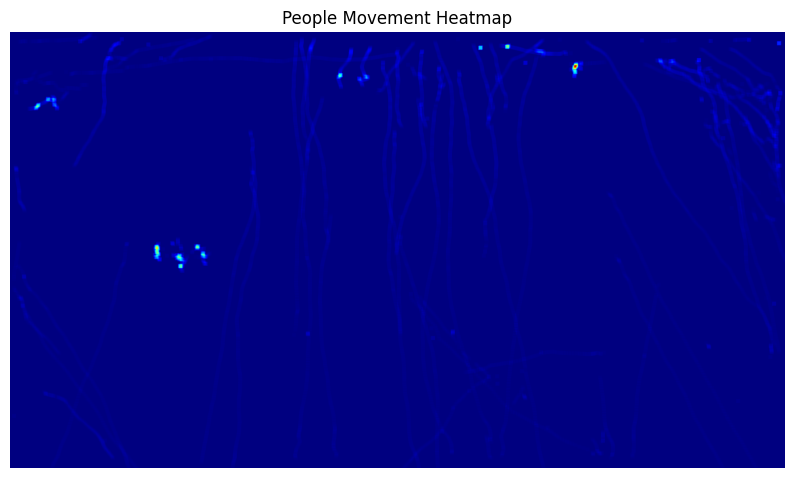

 Done! Check 'output_people_flow.mp4' and 'heatmap.png'


In [13]:
heatmap_normalized = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap_colored = cv2.applyColorMap(heatmap_normalized.astype(np.uint8), cv2.COLORMAP_JET)

cv2.imwrite("heatmap.png", heatmap_colored)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB))
plt.title("People Movement Heatmap")
plt.axis("off")
plt.show()

print(" Done! Check 'output_people_flow.mp4' and 'heatmap.png'")